In [1]:
# Common imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (10, 5)

/Users/esachko/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Список литературы

1. "Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems", Géron, A., 2017, *O'Reilly Media*
2. "An Introduction to Statistical Learning: With Applications in R.", Gareth James, Daniela Witten, Trevor Hastie, and Robert Tibshirani, 2014, *Springer Publishing Company, Incorporated*
3. [Sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix)
4. "Scaling to Very Very Large Corpora for Natural Language Disambiguation", Michele Banko and Eric Brill, 2001, *Microsoft Research*

# Dimensionality reduction

Большинство ML задач предполагает работу с большим количеством фич. Большое количество фич не только замедляет работу алгоритмов, но и усложняет процесс поиска решения (curse of dimensionality). 

Например, среднее расстояние между двумя случайно выбранными точками в квадрате с длиной стороны равной 1 равно 0.52. В то же время в 1,000,000-размерном гиперкубе, с длиной стороны 1, среднее расстояние будет равно 408.52. Т.е. объекты в многомерном пространстве находятся далеко друг от друга, что требует от ML модели сильной экстраполяции и, как следствие, уменьшается точность.

В целом dimensionality reduction призван лишь уменьшить размерность данных, чтобы ускорить процесс обучения. Побочными эффектами (!) могут стать уменьшение шумов и улучшение обобщающих свойств модели.

Часто для визуализации данных используют уменьшение пространства до 2D и 3D.

Два основных способа уменьшения пространства: projection и manifold learning.

### Projection

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

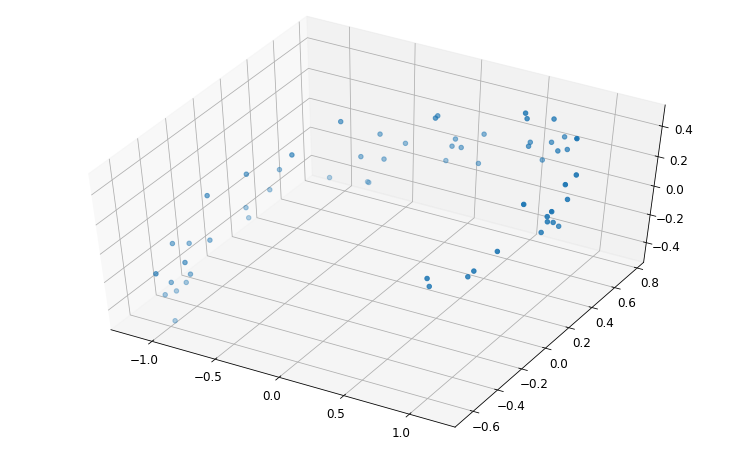

In [3]:
fig = plt.figure(figsize=(10,6))
ax = axes3d.Axes3D(fig, azim=300, elev=50)
ax.scatter3D(X[:, 0], X[:, 1], X[:, 2])

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

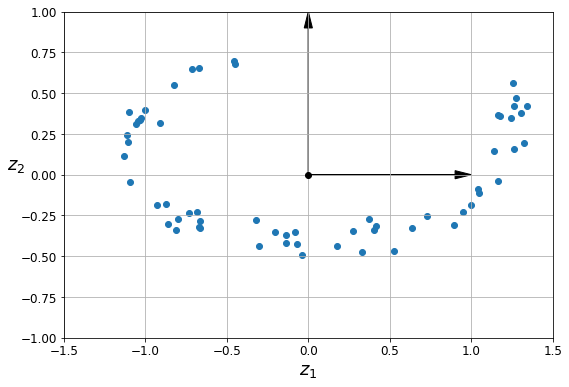

In [5]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, aspect='equal')
ax.scatter(X2D[:, 0], X2D[:, 1])
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.5, -1, 1])
ax.grid(True)

Т.е. мы проецируем исходные данные в новое пространство меньшего размера, пытаясь сохранить как можно больше исходного variance.

### Manifold learning

В некоторых случаях обычного проецирования недостаточно.

In [6]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

(-12, 15)

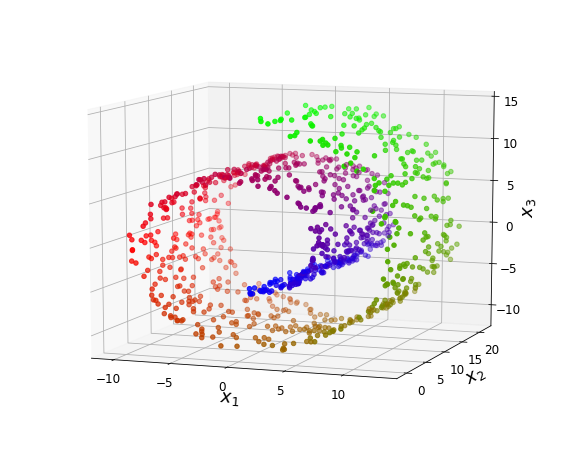

In [7]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.brg)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

Manifold learning пытается найти оптимальный manifold, описывающий исходные данные.

In [8]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

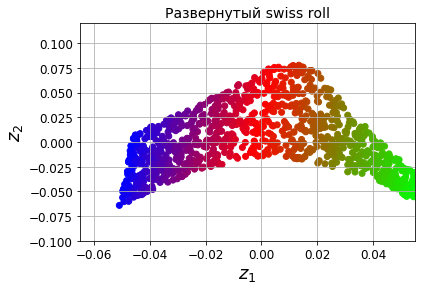

In [10]:
plt.title("Развернутый swiss roll", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.brg)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

`LocallyLinearEmbedding` изучает линейные связи между точками в исходном пространстве, после чего пытается перейти в меньшее пространство, сохранив при этом линейные связи.

## PCA

Самый популярный способ проекции данных. PCA итеративно проецирует исходные данные на компоненты (оси). Каждая новая компонента должна быть ортогональна предыдущей и описывать максимальное количество остаточного variance.

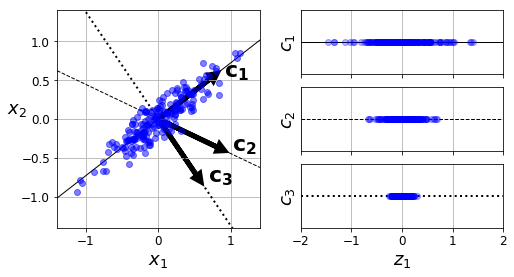

In [11]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])

plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u2[0], u2[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')

plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u2[0] + 0.1, u2[1], r"$\mathbf{c_2}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_3}$", fontsize=22)

plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.ylabel("$c_1$", fontsize=18)
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.ylabel("$c_2$", fontsize=18)
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3, 2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.ylabel("$c_3$", fontsize=18)
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

На картинке выше изображены три компоненты и variance, описанный каждой из них. 

Для подбора оптимального количества компонент используют метод "локтя" (elbow method). Метод итеративно увеличивает количество компонент и на каждой итерации вычисляет процент variance исходных данных, описанный всеми компонентами, добавленными до этой итерации. Если принять количество компонент за ось X, а процент описанного variance за Y, то получится изображение похожее на локоть. Оно демонстрирует оптимальное количество компонент для объяснения исходных данных.

Text(0,0.5,'explained_variance_ratio_')

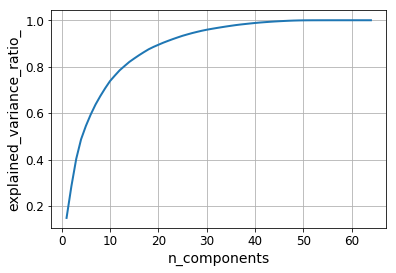

In [12]:
from sklearn import datasets
digits = datasets.load_digits()
X_digits = digits.data
pca = PCA().fit(X_digits)

cum_evr = np.cumsum(pca.explained_variance_ratio_)
xs = np.arange(cum_evr.size) + 1
plt.plot(xs, cum_evr, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

In [20]:
# pca.components_

## Kernel PCA

In [21]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

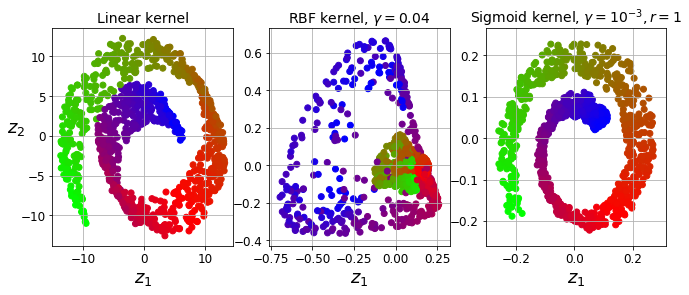

In [22]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.brg)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

## MDS, Isomap and t-SNE

In [23]:
from sklearn.manifold import MDS, Isomap, TSNE

# уменьшает размерность, пытаясь сохранить расстояние между объектами
mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

# создает граф, соединяя объекты с их ближайшими соседями
# уменьшает размерность, пытаясь сохранить геодезическое расстояние 
# (количество узлов в кратчайшем пути между двумя исходными вершинами графа)
isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

# уменьшает размерность, пытаясь сохранить близкие в исходном пространстве объекты ближе друг к другу, 
# а далекие подальше друг от друга (часто используется для визуализации кластеров)
tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

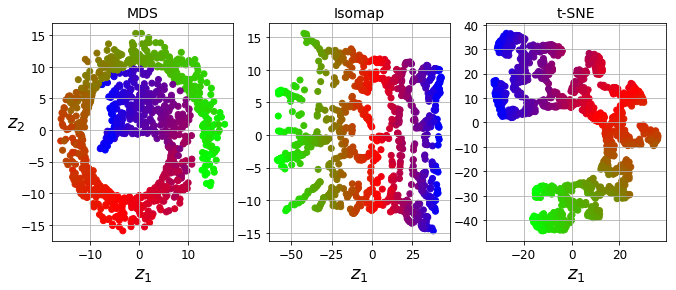

In [24]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles, (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.brg)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

#### Подробнее в [1], глава 8

А здесь можно поиграть с визуализацией: http://projector.tensorflow.org/

# Разреженные матрицы

**Разреженная матрица** - матрица, в которой большая часть элементов нули. 

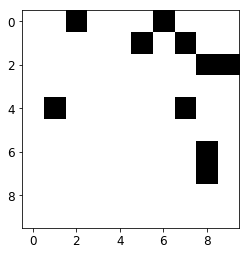

In [25]:
from sklearn.preprocessing import binarize
from scipy import sparse

sm = binarize(sparse.rand(10, 10, density=0.1, random_state=42))
plt.imshow(sm.todense(), cmap=matplotlib.cm.binary)

In [26]:
density = sm.nnz / (sm.shape[0] * sm.shape[1])
print("Density (плотность): ", density)
print("Sparsity (разреженность): ", 1 - density)

Density (плотность):  0.1
Sparsity (разреженность):  0.9


In [27]:
# плотное представление матрицы
sm.todense()

matrix([[0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [28]:
print("Dense matrix memory usage:", sm.todense().nbytes)
print("CSR matrix memory usage:", sm.data.nbytes + sm.indices.nbytes + sm.indptr.nbytes)

Dense matrix memory usage: 800
CSR matrix memory usage: 164


In [29]:
big_sm = binarize(sparse.rand(1000, 1000, density=0.001, random_state=42))
print("Dense matrix memory usage (kB):", big_sm.todense().nbytes / 1024)
print("CSR matrix memory usage (kB):", (big_sm.data.nbytes + big_sm.indices.nbytes + big_sm.indptr.nbytes) / 1024)

Dense matrix memory usage (kB): 7812.5
CSR matrix memory usage (kB): 15.62890625


Для хранения плотной матрицы требуется объем памяти, пропорциональный $m \times n$, где $m$ - количество строк, $n$ - количество столбцов (т.к. данные хранятся как список списков). Т.е. хранить большие матрицы дорого, а когда они более чем на $99\%$ заполнены нулями, еще и невыгодно. Для компрессии таких матриц используют разреженные матрицы. К сожалению, за это приходится платить необходимостью адаптировать алгоритмы для работы с разреженными матрицами. 

Существующие форматы для хранения разреженных матриц: DOK, LIL, COO, CSR, CSC, ...

## DOK, LIL, COO

Эффективны: для быстрого создания и изменения матриц

Не эффективны: для арифметических операций

In [30]:
tm = binarize(np.random.rand(10, 10), threshold=0.9)
print("Плотность:", tm[tm > 0].size / (tm.shape[0] * tm.shape[1]))
tm

Плотность: 0.1


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Dictionary of keys (DOK)

In [31]:
dok_sm = sparse.dok_matrix(tm, shape=tm.shape)
dok_sm

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Dictionary Of Keys format>

In [32]:
print("Как в теории хранятся данные\n")
dict(dok_sm.items())

Как в теории хранятся данные



{(1, 1): 1.0,
 (1, 4): 1.0,
 (2, 7): 1.0,
 (2, 9): 1.0,
 (4, 4): 1.0,
 (5, 0): 1.0,
 (5, 6): 1.0,
 (6, 6): 1.0,
 (7, 6): 1.0,
 (8, 3): 1.0}

### List of lists (LIL)

In [33]:
lil_sm = sparse.lil_matrix(tm, shape=tm.shape)
lil_sm

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in LInked List format>

In [34]:
print("Как в теории хранятся данные\n")
fmt = "%-6s | %s"
print(fmt % ("row_id", "данные"))
print("-" * 50)
for row_id in range(lil_sm.shape[0]):
    print(fmt % (
        row_id, 
        list(zip(lil_sm.rows[row_id], lil_sm.data[row_id]))
    ))

Как в теории хранятся данные

row_id | данные
--------------------------------------------------
0      | []
1      | [(1, 1.0), (4, 1.0)]
2      | [(7, 1.0), (9, 1.0)]
3      | []
4      | [(4, 1.0)]
5      | [(0, 1.0), (6, 1.0)]
6      | [(6, 1.0)]
7      | [(6, 1.0)]
8      | [(3, 1.0)]
9      | []


### Coordinate list (COO)

In [35]:
coo_sm = sparse.coo_matrix(tm, shape=tm.shape)
coo_sm

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in COOrdinate format>

In [36]:
print("Как в теории хранятся данные\n")
[tpl for tpl in zip(coo_sm.row, coo_sm.col, coo_sm.data)]

Как в теории хранятся данные



[(1, 1, 1.0),
 (1, 4, 1.0),
 (2, 7, 1.0),
 (2, 9, 1.0),
 (4, 4, 1.0),
 (5, 0, 1.0),
 (5, 6, 1.0),
 (6, 6, 1.0),
 (7, 6, 1.0),
 (8, 3, 1.0)]

## CSR, CSC

Эффективны: для арифметических операций

Не эффективны: для быстрого создания и изменения матриц

### Compressed sparse row (CSR)

In [37]:
csr_sm = sparse.csr_matrix(tm, shape=tm.shape)
csr_sm

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [38]:
tm

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [39]:
print("A: ", csr_sm.data)
print("IA: ", csr_sm.indptr)
print("JA: ", csr_sm.indices)

A:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
IA:  [ 0  0  2  4  4  5  7  8  9 10 10]
JA:  [1 4 7 9 4 0 6 6 6 3]


### Compressed sparse column (CSC)

In [40]:
csc_sm = sparse.csc_matrix(tm, shape=tm.shape)
csc_sm

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Column format>

In [41]:
tm

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [42]:
print("A: ", csc_sm.data)
print("IA: ", csc_sm.indptr)
print("JA: ", csc_sm.indices)

A:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
IA:  [ 0  1  2  2  3  5  5  8  9  9 10]
JA:  [5 1 8 1 4 5 6 7 2 2]


## Особенности scipy.sparse

In [43]:
rows, cols = csr_sm.nonzero()

In [44]:
%%time
sm = sparse.lil_matrix(csc_sm.shape)
for row_id, col_id in zip(rows, cols):
    sm[row_id, col_id] = 1

CPU times: user 499 µs, sys: 413 µs, total: 912 µs
Wall time: 8.75 ms


In [45]:
%%time
sm = sparse.csr_matrix(csc_sm.shape)
for row_id, col_id in zip(rows, cols):
    sm[row_id, col_id] = 1

CPU times: user 7 ms, sys: 1.87 ms, total: 8.87 ms
Wall time: 16.1 ms


/Users/esachko/miniconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


### но, ...

In [46]:
%%time
sm = sparse.lil_matrix(tm.shape)
for row_id, col_id in zip(rows, cols):
    sm[row_id, col_id] = 1
_ = sm.tocsr()

CPU times: user 347 µs, sys: 10 µs, total: 357 µs
Wall time: 354 µs


In [47]:
%%time
_ = sparse.csr_matrix((np.ones(len(rows)), (rows, cols)), tm.shape)

CPU times: user 417 µs, sys: 32 µs, total: 449 µs
Wall time: 427 µs


### а если данных больше, то ...

In [49]:
sm = sparse.rand(1000, 1000, 0.01)
shape = sm.shape
rows, cols = sm.nonzero()
data = sm.data

In [50]:
%%time
sm = sparse.lil_matrix(shape)
for row_id, col_id, val in zip(rows, cols, data):
    sm[row_id, col_id] = val
_ = sm.tocsr()

CPU times: user 60.4 ms, sys: 1.73 ms, total: 62.1 ms
Wall time: 61.2 ms


In [51]:
%%time
_ = sparse.csr_matrix((data, (rows, cols)), shape)

CPU times: user 1.72 ms, sys: 913 µs, total: 2.64 ms
Wall time: 1.64 ms


В примере с lil_matrix много времени тратится на итерацию по циклу и на поэлементное заполнение матрицы.

#### Подробнее в [3] и в документации к `scipy.sparse`